In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [2]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

In [3]:
data_dir = '../input/data/train/images_classified/'
dataset = datasets.ImageFolder(os.path.join(data_dir), transforms)

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 18900
    Root location: ../input/data/train/images_classified/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
class_names = dataset.classes
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

In [7]:
train_set, valid_set = torch.utils.data.random_split(dataset, [train_size, valid_size])

In [8]:
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=8)
dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)

In [14]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    # pytorch는 batch, channel, 높이, 너비 순으로 데이터 구성.
    input = input.numpy().transpose((1, 2, 0)) # channel 값이 가장 뒤에 오도록.
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()

'''
# 학습 데이터를 배치 단위로 불러오기
iterator = iter(dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes= next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
'''

'\n# 학습 데이터를 배치 단위로 불러오기\niterator = iter(dataloader)\n\n# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화\ninputs, classes= next(iterator)\nout = torchvision.utils.make_grid(inputs)\nimshow(out, title=[class_names[x] for x in classes])\n'

In [10]:
model = models.resnet34(pretrained=True)

num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 18개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 18) 
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
#num_epochs = 50
num_epochs = 10
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad() # 전체 grad 값을 초기화.
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_set)
    epoch_acc = running_corrects / len(train_set) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

  0%|          | 0/119 [00:00<?, ?it/s]

#0 Loss: 1.2791 Acc: 63.5185% Time: 982.5978s


  0%|          | 0/119 [00:00<?, ?it/s]

#1 Loss: 0.4315 Acc: 87.5000% Time: 1963.0354s


  0%|          | 0/119 [00:00<?, ?it/s]

#2 Loss: 0.2760 Acc: 91.2963% Time: 2947.2464s


  0%|          | 0/119 [00:00<?, ?it/s]

#3 Loss: 0.1993 Acc: 93.7897% Time: 3929.6649s


  0%|          | 0/119 [00:00<?, ?it/s]

#4 Loss: 0.1449 Acc: 95.7474% Time: 4908.1767s


  0%|          | 0/119 [00:00<?, ?it/s]

#5 Loss: 0.1087 Acc: 97.0172% Time: 5885.6935s


  0%|          | 0/119 [00:00<?, ?it/s]

#6 Loss: 0.0814 Acc: 97.8968% Time: 6867.0584s


  0%|          | 0/119 [00:00<?, ?it/s]

#7 Loss: 0.0631 Acc: 98.6905% Time: 7847.4666s


  0%|          | 0/119 [00:00<?, ?it/s]

#8 Loss: 0.0457 Acc: 99.1336% Time: 8823.8568s


100%|██████████| 119/119 [16:20<00:00,  8.24s/it]

#9 Loss: 0.0347 Acc: 99.4312% Time: 9804.3057s


In [12]:
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=True, num_workers=8)

[예측 결과: 0] (실제 정답: 0)


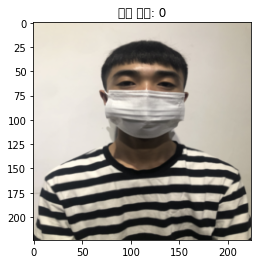

[예측 결과: 1] (실제 정답: 1)


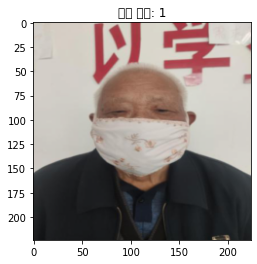

[예측 결과: 3] (실제 정답: 3)


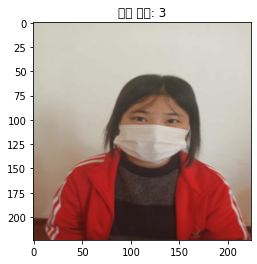

[예측 결과: 3] (실제 정답: 0)


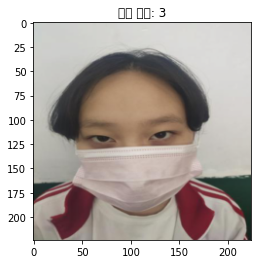

[예측 결과: 9] (실제 정답: 9)


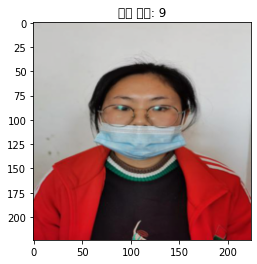

[예측 결과: 1] (실제 정답: 1)


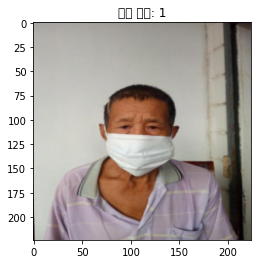

[예측 결과: 10] (실제 정답: 10)


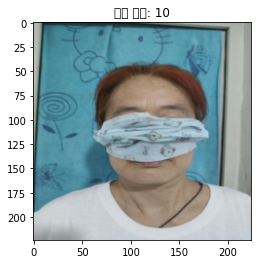

[예측 결과: 13] (실제 정답: 12)


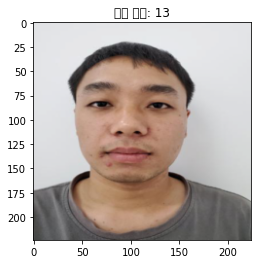

[예측 결과: 1] (실제 정답: 1)


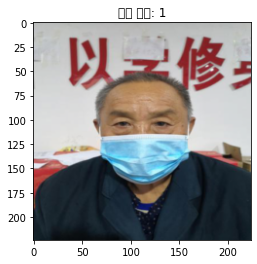

[예측 결과: 3] (실제 정답: 3)


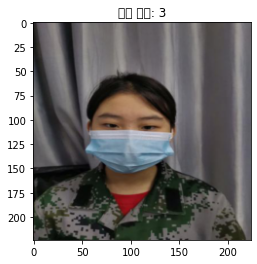

[예측 결과: 4] (실제 정답: 4)


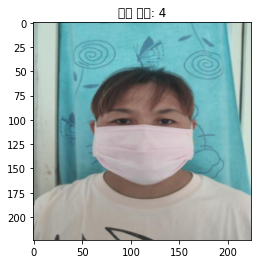

[예측 결과: 13] (실제 정답: 14)


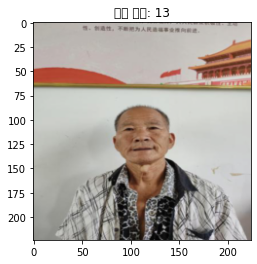

[예측 결과: 0] (실제 정답: 0)


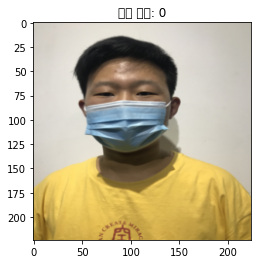

[예측 결과: 4] (실제 정답: 4)


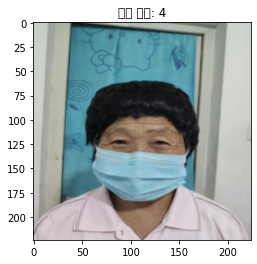

[예측 결과: 3] (실제 정답: 3)


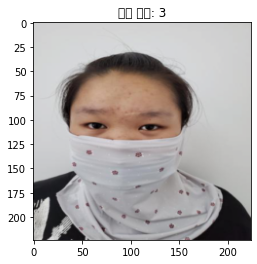

[예측 결과: 10] (실제 정답: 10)


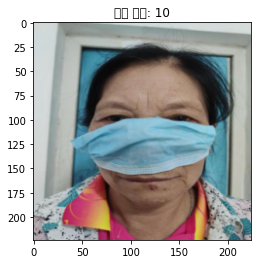

[예측 결과: 15] (실제 정답: 15)


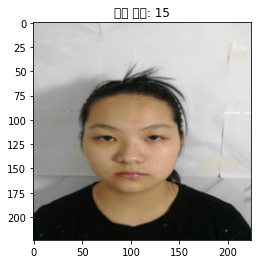

[예측 결과: 0] (실제 정답: 0)


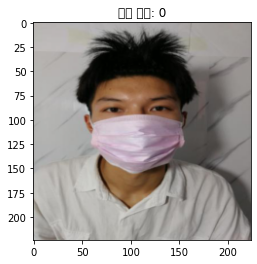

[예측 결과: 2] (실제 정답: 2)


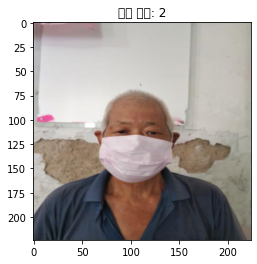

[예측 결과: 3] (실제 정답: 3)


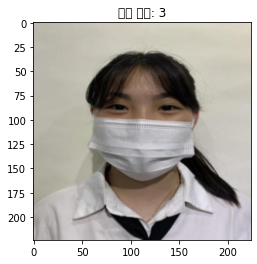

[예측 결과: 3] (실제 정답: 3)


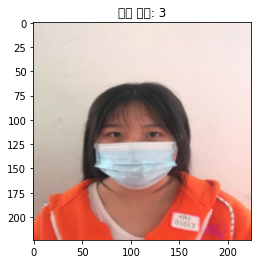

[예측 결과: 3] (실제 정답: 3)


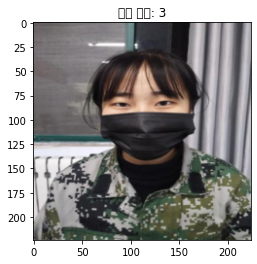

[예측 결과: 15] (실제 정답: 15)


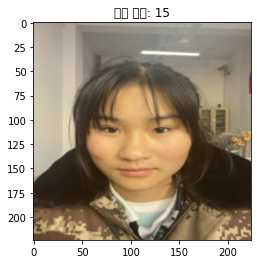

[예측 결과: 10] (실제 정답: 10)


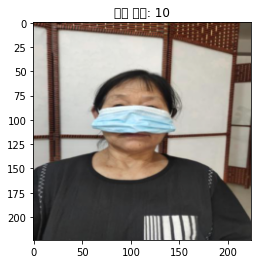

[예측 결과: 1] (실제 정답: 1)


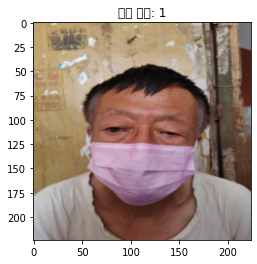

[예측 결과: 3] (실제 정답: 3)


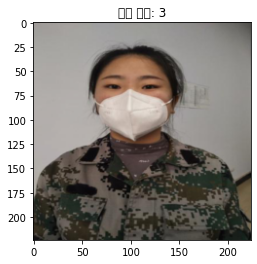

[예측 결과: 1] (실제 정답: 1)


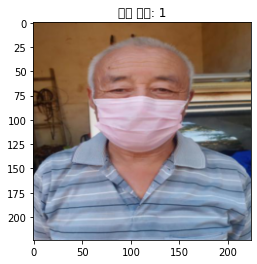

[예측 결과: 4] (실제 정답: 4)


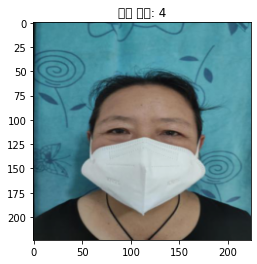

[예측 결과: 9] (실제 정답: 9)


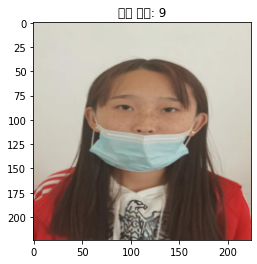

[예측 결과: 6] (실제 정답: 6)


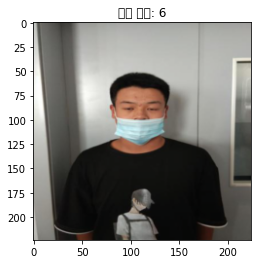

[Test Phase] Loss: 0.1575 Acc: 95.0794% Time: 95.1054s


In [46]:
model.eval()
start_time = time.time()

all_labels = []
all_preds = []

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in valid_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        #all_preds.append(preds)
        
        for p in preds.numpy():
            all_preds.append(p)
        
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        
        #all_labels.append(labels.data)
        
        for l in labels.data.numpy():
            all_labels.append(l)
        
        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(valid_set)
    epoch_acc = running_corrects / len(valid_set) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [49]:
#all_preds

In [50]:
#all_labels

In [41]:
# !conda install -c conda-forge torchmetrics -y

In [54]:
from sklearn.metrics import f1_score
#from torchmetrics import F1Score

#f1 = F1Score(num_classes=18)
#f1(all_preds, all_labels)
f1_score(all_labels, all_preds, average='macro')

0.871437293012491

In [59]:
import pandas as pd

test_dir = '/opt/ml/input/data/eval'

In [62]:
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

In [63]:
submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,0
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,0
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,0
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,0


In [64]:
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

In [66]:
#image_paths

In [68]:
from torch.utils.data import Dataset, DataLoader

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [70]:
test_set = TestDataset(image_paths, transforms)

In [71]:
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

In [105]:
def imshow_test(input):
    # torch.Tensor를 numpy 객체로 변환
    # pytorch는 batch, channel, 높이, 너비 순으로 데이터 구성.
    input = input.numpy().transpose((1, 2, 0)) # channel 값이 가장 뒤에 오도록.
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    #plt.title(title)
    plt.show()

In [111]:
'''
# 데이터를 배치 단위로 불러오기
iterator = iter(test_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow_test(out)
'''

'\n# 데이터를 배치 단위로 불러오기\niterator = iter(test_dataloader)\n\n# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화\ninputs = next(iterator)\nout = torchvision.utils.make_grid(inputs)\nimshow_test(out)\n'

In [100]:
all_predictions = []

with torch.no_grad():
    for inputs in tqdm(test_dataloader):
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_predictions.extend(preds.cpu().numpy())

100%|██████████| 99/99 [04:56<00:00,  3.00s/it]


In [101]:
'''
from PIL import Image

all_predictions = []
for images in tqdm(test_dataloader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
'''

'\nfrom PIL import Image\n\nall_predictions = []\nfor images in tqdm(test_dataloader):\n    with torch.no_grad():\n        images = images.to(device)\n        pred = model(images)\n        pred = pred.argmax(dim=-1)\n        all_predictions.extend(pred.cpu().numpy())\n'

In [102]:
for i in range(len(all_predictions)):
    print(all_predictions[i], end=' ')
    
    if i % 5 == 4:
        print()
    
    if i == 19:
        break

5 1 5 5 4 
0 15 11 13 11 
5 11 14 11 0 
12 1 1 15 1 


In [77]:
class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [103]:
all_predictions2 = []

for p in all_predictions:
    all_predictions2.append(class_names[p])

In [104]:
for i in range(len(all_predictions2)):
    print(all_predictions2[i], end=' ')
    
    if i % 5 == 4:
        print()
    
    if i == 19:
        break

13 1 13 13 12 
0 7 3 5 3 
13 3 6 3 0 
4 1 1 7 1 


In [86]:
submission['ans'] = all_predictions2

In [87]:
submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,4
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


In [88]:
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)

In [112]:
#model.state_dict()

In [113]:
os.getcwd()

'/opt/ml/code'

In [115]:
torch.save(model.state_dict(), os.getcwd()+'/'+'2nd_model_run')